In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

np.random.seed(7)

In [2]:
dest = '/content/drive/MyDrive/HSE Final Project/to_train'
name = 'submit_10_abandoned.csv'

df = pd.read_csv(dest + '/' + name)
df.shape

(10913804, 44)

In [3]:
df['shop_id'] = df['shop_id'].astype(np.int8)
df['item_id'] = df['item_id'].astype(np.int16)
df['month'] = df['month'].astype(np.int8)
df['year'] = df['year'].astype(np.int16)
df['date_block_num'] = df['date_block_num'].astype(np.int8)
df['item_cnt'] = df['item_cnt'].astype(np.int32)
df['prev_value'] = df['prev_value'].astype(np.int32)
df['prev_value_year'] = df['prev_value_year'].astype(np.int32)
df['shop_city'] = df['shop_city'].astype(np.int8)
df['shop_category'] = df['shop_category'].astype(np.int8)
df['item_category_id'] = df['item_category_id'].astype(np.int8)
df['digital'] = df['digital'].astype(np.bool_)
df['category_type'] = df['category_type'].astype(np.int8)
df['category_subtype'] = df['category_subtype'].astype(np.int8)
df['item_cnt_lag_2'] = df['item_cnt_lag_2'].astype(np.int32)
df['item_cnt_lag_3'] = df['item_cnt_lag_3'].astype(np.int32)
df['item_cnt_lag_4'] = df['item_cnt_lag_4'].astype(np.int32)
df['item_cnt_lag_5'] = df['item_cnt_lag_5'].astype(np.int32)
df['item_cnt_lag_6'] = df['item_cnt_lag_6'].astype(np.int32)

for col in df.columns[22:40]:
    df[col] = df[col].astype(np.int32)

df.head()

,shop_id,item_id,month,year,date_block_num,item_cnt,item_price,prev_value,prev_value_year,stock_prev,stock_prev_year,shop_city,shop_category,item_category_id,digital,category_type,category_subtype,item_cnt_lag_2,item_cnt_lag_3,item_cnt_lag_4,item_cnt_lag_5,item_cnt_lag_6,cnt_block_shop_lag_1,cnt_block_shop_lag_2,cnt_block_shop_lag_3,cnt_block_shop_lag_4,cnt_block_shop_lag_5,cnt_block_shop_lag_12,cnt_block_item_lag_1,cnt_block_item_lag_2,cnt_block_item_lag_3,cnt_block_item_lag_4,cnt_block_item_lag_5,cnt_block_item_lag_12,cnt_block_category_lag_1,cnt_block_category_lag_2,cnt_block_category_lag_3,cnt_block_category_lag_4,cnt_block_category_lag_5,cnt_block_category_lag_12,date_item_avg_item_cnt,shop_item_avg_item_cnt,cat_item_avg_item_cnt,delta_price_lag
0,0,19,1,2013,0,0,0.0,0,0,0.0,0.0,29,4,40,False,7,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.02222,0.0,0.02222,-1.0
1,0,27,1,2013,0,0,0.0,0,0,0.0,0.0,29,4,19,False,5,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.15550,0.0,0.05682,-1.0
2,0,28,1,2013,0,0,0.0,0,0,0.0,0.0,29,4,30,False,5,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.17770,0.0,0.14120,-1.0
3,0,29,1,2013,0,0,0.0,0,0,0.0,0.0,29,4,23,False,5,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.08887,0.0,0.03738,-1.0
4,0,32,1,2013,0,6,221.0,0,0,0.0,0.0,29,4,40,False,7,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.64500,8.0,1.31900,-1.0


In [4]:
df = df[df.date_block_num >= 12]
df.reset_index(drop=True, inplace=True)
df.shape

(6425094, 44)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6425094 entries, 0 to 6425093
Data columns (total 44 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   shop_id                    int8   
 1   item_id                    int16  
 2   month                      int8   
 3   year                       int16  
 4   date_block_num             int8   
 5   item_cnt                   int32  
 6   item_price                 float64
 7   prev_value                 int32  
 8   prev_value_year            int32  
 9   stock_prev                 float64
 10  stock_prev_year            float64
 11  shop_city                  int8   
 12  shop_category              int8   
 13  item_category_id           int8   
 14  digital                    bool   
 15  category_type              int8   
 16  category_subtype           int8   
 17  item_cnt_lag_2             int32  
 18  item_cnt_lag_3             int32  
 19  item_cnt_lag_4             int32  
 20  it

Due to the fact that we predict future, it makes no sense to shuffle the data

**Best Params:**

*   Max_depth: 8
*   Min_child_weight: 10
*   col_sample_by_tree: 0.8
*   eta: 0.05
*   n_estimators: 300
*   subsample: 0.9
*   gamma: 0.5


---


The best estimator across ALL searched params:
 XGBRegressor(colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=8,
             min_child_weight=10, n_estimators=300,
             objective='reg:squarederror', random_state=13, subsample=0.9,
             tree_method='gpu_hist', verbosity=2)

In [6]:
col_sample_by_tree = 0.8
gamma = 1
eta = 0.3
max_depth = 9
min_child_weight = 0.5
n_estimators = 900
subsample = 0.8

gp = 'gpu_hist'
obj = 'reg:squarederror'
random_state = 13
verbosity = 2

In [7]:
xgbr = xgb.XGBRegressor(col_sample_by_tree=col_sample_by_tree,
#                         gamma=gamma,
                        eta=eta,
                        max_depth=max_depth,
                        min_child_weight=min_child_weight,
                        n_estimators=n_estimators,
                        subsample=subsample,
                        tree_method=gp,
                        objective=obj,
                        random_state=random_state,
                        verbosity=verbosity)

In [8]:
X_train = df[df.date_block_num < 33].drop(['item_cnt'], axis=1)
y_train = df[df.date_block_num < 33]['item_cnt']
X_valid = df[df.date_block_num == 33].drop(['item_cnt'], axis=1)
y_valid = df[df.date_block_num == 33]['item_cnt']

In [9]:
eval_set = [(X_train, y_train), (X_valid, y_valid)]

In [10]:
xgbr.fit(X_train, y_train,
         eval_metric=['rmse', 'rmse'], eval_set=eval_set,
         early_stopping_rounds=400, verbose=2)

[0]	validation_0-rmse:3.26889	validation_1-rmse:5.15259
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 400 rounds.
[2]	validation_0-rmse:2.81718	validation_1-rmse:4.96907
[4]	validation_0-rmse:2.45803	validation_1-rmse:4.71941
[6]	validation_0-rmse:2.16132	validation_1-rmse:4.55268
[8]	validation_0-rmse:1.91745	validation_1-rmse:4.42838
[10]	validation_0-rmse:1.72111	validation_1-rmse:4.32828
[12]	validation_0-rmse:1.57474	validation_1-rmse:4.19979
[14]	validation_0-rmse:1.45299	validation_1-rmse:4.17365
[16]	validation_0-rmse:1.35149	validation_1-rmse:4.11054
[18]	validation_0-rmse:1.26744	validation_1-rmse:4.06225
[20]	validation_0-rmse:1.18869	validation_1-rmse:4.0184
[22]	validation_0-rmse:1.12666	validation_1-rmse:4.01661
[24]	validation_0-rmse:1.07497	validation_1-rmse:3.99593
[26]	validation_0-rmse:1.02419	validation_1-rmse:3.98059
[28]	validation_0-rmse:0.989424	validation_1-rms

XGBRegressor(col_sample_by_tree=0.8, eta=0.3, max_depth=9, min_child_weight=0.5,
             n_estimators=900, objective='reg:squarederror', random_state=13,
             subsample=0.8, tree_method='gpu_hist', verbosity=2)

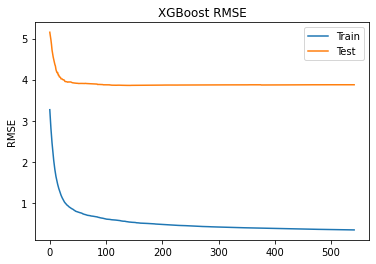

In [11]:
import matplotlib.pyplot as plt

# retrieve performance metrics
results = xgbr.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

# plot rmse
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error

y_pred = xgbr.predict(X_valid)
y_pred_rounded = np.around(y_pred)
mse = mean_squared_error(y_valid, y_pred)
mse_rd = mean_squared_error(y_valid, y_pred_rounded)

print('MSE: %.2f' % mse)
print('RMSE: %.2f' % (mse ** (0.5)))

print('MSE (rounded): %.2f' % mse_rd)
print('RMSE (rounded): %.2f' % (mse_rd ** (0.5)))

MSE: 14.89
RMSE: 3.86
MSE (rounded): 14.90
RMSE (rounded): 3.86


In [13]:
# import pickle

# dest = '/content/drive/MyDrive/HSE Final Project/Models/'
# file_name = 'xgb_reg_1.pkl'

# save
# pickle.dump(xgbr, open(dest + file_name, 'wb'))

In [14]:
# import pickle

# dest = '/content/drive/MyDrive/HSE Final Project/Models/'
# file_name = 'xgb_reg_1.pkl'
# load
# xgbr = pickle.load(open(dest + file_name, "rb"))

In [15]:
dest = '/content/drive/MyDrive/HSE Final Project/to_test'
name = 'submit_10_test.csv'

test_df = pd.read_csv(dest + '/' + name)
test_df.head()

,shop_id,item_id,month,year,date_block_num,item_price,prev_value,prev_value_year,stock_prev,stock_prev_year,shop_city,shop_category,item_category_id,digital,category_type,category_subtype,item_cnt_lag_2,item_cnt_lag_3,item_cnt_lag_4,item_cnt_lag_5,item_cnt_lag_6,cnt_block_shop_lag_1,cnt_block_shop_lag_2,cnt_block_shop_lag_3,cnt_block_shop_lag_4,cnt_block_shop_lag_5,cnt_block_shop_lag_12,cnt_block_item_lag_1,cnt_block_item_lag_2,cnt_block_item_lag_3,cnt_block_item_lag_4,cnt_block_item_lag_5,cnt_block_item_lag_12,cnt_block_category_lag_1,cnt_block_category_lag_2,cnt_block_category_lag_3,cnt_block_category_lag_4,cnt_block_category_lag_5,cnt_block_category_lag_12,date_item_avg_item_cnt,shop_item_avg_item_cnt,cat_item_avg_item_cnt,delta_price_lag
0,5,5037,11,2015,34,2599.0,0,1,0.0,2599.0,3,3,19,False,5,9,1,3,1,1,1,1052,1092,1294,991,954,1445,25,110,119,54,105,65,21346,24604,23616,19872,22261,49726,0.0,0.9287,1.951,-1188.0000
1,5,5320,11,2015,34,0.0,0,0,0.0,0.0,3,3,55,False,9,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0000,0.000,0.0000
2,5,5233,11,2015,34,1199.0,1,0,1199.0,0.0,3,3,19,False,5,9,3,1,0,2,3,1052,1092,1294,991,954,0,42,80,150,37,119,0,21346,24604,23616,19872,22261,0,0.0,1.4290,1.657,6.0980
3,5,5232,11,2015,34,599.0,0,0,0.0,0.0,3,3,23,False,5,18,0,1,0,0,0,1052,1092,1294,0,0,0,28,48,65,0,0,0,21346,24604,23616,0,0,0,0.0,0.3333,1.093,0.8545
4,5,5268,11,2015,34,0.0,0,0,0.0,0.0,3,3,20,False,5,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0000,0.000,0.0000


In [16]:
name_sample = 'sample_submission.csv'

sample = pd.read_csv(dest + '/' + name_sample)
sample.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [17]:
test_pred = xgbr.predict(test_df)
print(test_pred)

[ 2.0092472e-01 -1.9967556e-05  5.0828063e-01 ...  2.2858053e-01
 -1.9967556e-05  2.8579104e-01]


In [18]:
sample.item_cnt_month = np.around(test_pred)
sample.head()

,ID,item_cnt_month
0,0,0.0
1,1,-0.0
2,2,1.0
3,3,-0.0
4,4,0.0


In [19]:
dest = '/content/drive/MyDrive/HSE Final Project/submissions/'
sample.to_csv(dest + '#8 submission_new (xgb testing).csv', index=False)

In [20]:
from xgboost import plot_importance
import matplotlib.pyplot as plt


def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

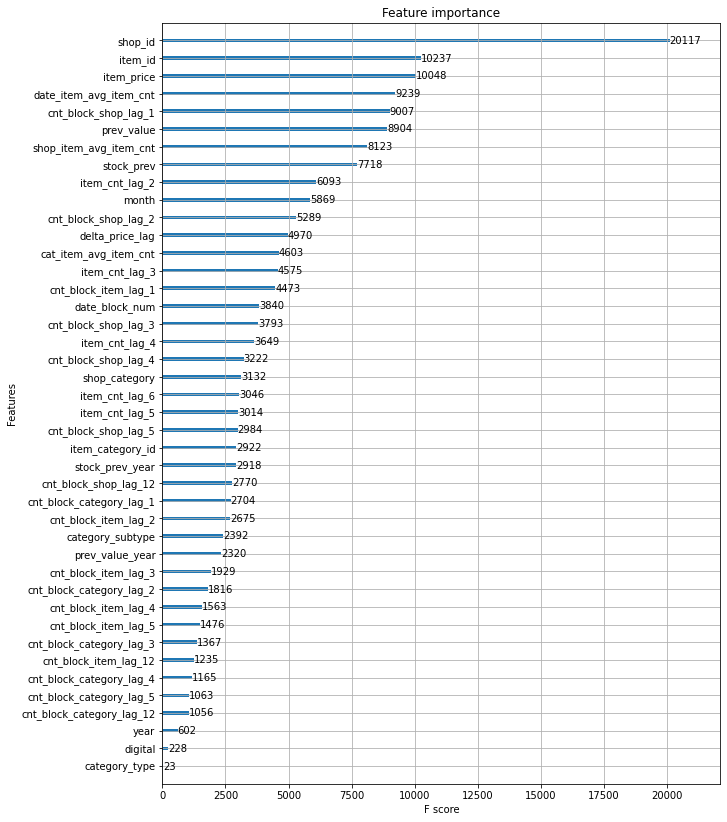

In [21]:
plot_features(xgbr, (10, 14))